In [1]:
import os
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torch.utils.data import random_split
from torchinfo import summary
import cv2
from transformers import default_data_collator, TrainerCallback
from transformers import TrainingArguments, Trainer, default_data_collator

2025-07-29 10:19:49.569753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753784389.843674      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753784389.915027      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Create PyTorch Dataset

In [2]:
# Replace these with your actual dimensions
IMG_WIDTH = 64
IMG_HEIGHT = 64
# Create the dataset (use dummy mean/std or precomputed ones)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

In [3]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, mean, std, is_train=True):
        self.is_train = is_train
        self.img_dir = img_dir
        self.images = os.listdir(img_dir)

        self.to_tensor = transforms.ToTensor()
        self.normalize_transform = transforms.Normalize(mean=mean, std=std)

    def __len__(self):
        return len(self.images)

    def create_mask(self, image_np):
        masked_image = image_np.copy()

        height, width = image_np.shape[:2]  # Dynamically get image dimensions

        # Prepare masking matrix
        mask = np.full((height, width, 3), 0, np.uint8)

        for _ in range(np.random.randint(1, 5)):
            x1, x2 = np.random.randint(1, width), np.random.randint(1, width)
            y1, y2 = np.random.randint(1, height), np.random.randint(1, height)
            thickness = np.random.randint(1, 15)
            cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

        masked_image = np.where(mask, 255 * np.ones_like(mask), masked_image)
        return masked_image

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        image_np = np.array(image)

        # Apply mask in NumPy domain
        masked_image_np = self.create_mask(image_np)

        # Convert both to tensors
        input_image = self.to_tensor(masked_image_np)
        target_image = self.to_tensor(image)

        # Normalize
        input_image = self.normalize_transform(input_image)
        target_image = self.normalize_transform(target_image)

        return {
            "pixel_values": input_image,  # input to the model
            "labels": target_image        # target for loss computation
        }

In [4]:
dataset = ImageDataset("/kaggle/input/aiomodule6vqa-coco-2014/val2014-resised", mean=mean, std=std)

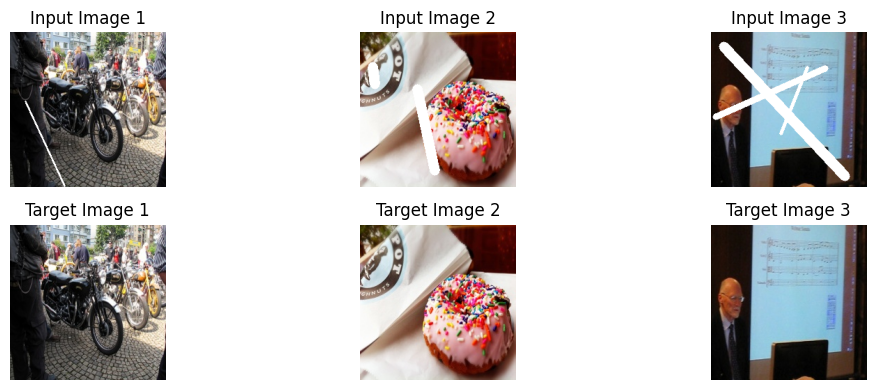

In [5]:
# Unnormalize function for visualization
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Plot 3 samples
plt.figure(figsize=(12, 4))
for i in range(3):
    sample = dataset[i]
    input_img =  sample["pixel_values"]
    target_img = sample["labels"]
    
    # Unnormalize for visualization
    input_img_vis = unnormalize(input_img.clone(), mean, std)
    target_img_vis = unnormalize(target_img.clone(), mean, std)

    # Plot input image
    plt.subplot(2, 3, i + 1)
    plt.imshow(F.to_pil_image(input_img_vis))
    plt.title(f"Input Image {i+1}")
    plt.axis("off")

    # Plot target image
    plt.subplot(2, 3, i + 4)
    plt.imshow(F.to_pil_image(target_img_vis))
    plt.title(f"Target Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Train_Test_split

In [6]:
from torch.utils.data import random_split

# Set the split ratios
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # Remaining samples

# Optional: Set a reproducible split
generator = torch.Generator().manual_seed(42)

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=generator
)

In [7]:
# Print dataset sizes
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Print shapes of one sample from each
sample_train = train_dataset[0]
sample_val = val_dataset[0]
sample_test = test_dataset[0]

print("\nSample Shapes:")
print(f"Train Sample - pixel_values: {sample_train['pixel_values'].shape}, labels: {sample_train['labels'].shape}")
print(f"Validation Sample - pixel_values: {sample_val['pixel_values'].shape}, labels: {sample_val['labels'].shape}")
print(f"Test Sample - pixel_values: {sample_test['pixel_values'].shape}, labels: {sample_test['labels'].shape}")


Train size: 6501
Validation size: 812
Test size: 814

Sample Shapes:
Train Sample - pixel_values: torch.Size([3, 224, 224]), labels: torch.Size([3, 224, 224])
Validation Sample - pixel_values: torch.Size([3, 224, 224]), labels: torch.Size([3, 224, 224])
Test Sample - pixel_values: torch.Size([3, 224, 224]), labels: torch.Size([3, 224, 224])


# Data Collector

In [8]:
data_collator=default_data_collator

# Creat Model

In [9]:
class FirstFeature(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FirstFeature, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, 2, 1, bias=False),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, in_channels, kernel_size=2, stride=2, padding=0, bias=False
            ),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
        )
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.conv(x)
        x = torch.concat([x, skip], dim=1)
        x = self.conv_block(x)
        return x

class FinalOutput(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FinalOutput, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Unet(nn.Module):
    def __init__(
        self, n_channels=3, n_classes=3, features=[64, 128, 256, 512, 1024],
    ):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Initial conv layers
        self.in_conv1 = FirstFeature(n_channels, features[0])
        self.in_conv2 = ConvBlock(features[0], features[0])

        # Encoder blocks
        self.enc_1 = Encoder(features[0], features[1])
        self.enc_2 = Encoder(features[1], features[2])
        self.enc_3 = Encoder(features[2], features[3])
        self.enc_4 = Encoder(features[3], features[4])

        # Decoder blocks
        self.dec_1 = Decoder(features[4], features[3])
        self.dec_2 = Decoder(features[3], features[2])
        self.dec_3 = Decoder(features[2], features[1])
        self.dec_4 = Decoder(features[1], features[0])

        # Output layer
        self.out_conv = FinalOutput(features[0], n_classes)

    def forward(self, pixel_values, labels=None):
        # Forward pass
        x = self.in_conv1(pixel_values)
        x1 = self.in_conv2(x)
        x2 = self.enc_1(x1)
        x3 = self.enc_2(x2)
        x4 = self.enc_3(x3)
        x5 = self.enc_4(x4)

        x = self.dec_1(x5, x4)
        x = self.dec_2(x, x3)
        x = self.dec_3(x, x2)
        x = self.dec_4(x, x1)

        output = self.out_conv(x)

        if labels is not None:
            # Compute MSE loss for inpainting
            loss = F.mse_loss(output, labels)
            return {"loss": loss, "logits": output}
        else:
            return {"logits": output}

In [11]:
model = Unet()
summary(model, input_size=(1, 3, 224, 224))  

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [1, 3, 224, 224]          --
├─FirstFeature: 1-1                           [1, 64, 224, 224]         --
│    └─Sequential: 2-1                        [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-1                       [1, 64, 224, 224]         192
│    │    └─LeakyReLU: 3-2                    [1, 64, 224, 224]         --
├─ConvBlock: 1-2                              [1, 64, 224, 224]         --
│    └─Sequential: 2-2                        [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-3                       [1, 64, 224, 224]         36,864
│    │    └─BatchNorm2d: 3-4                  [1, 64, 224, 224]         128
│    │    └─LeakyReLU: 3-5                    [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-6                       [1, 64, 224, 224]         36,864
│    │    └─BatchNorm2d: 3-7                  [1, 64, 224, 224]         128
│    │   

# Train and Evaluation

In [12]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    eval_strategy="epoch",      
    save_strategy="epoch",
    logging_strategy="epoch",         # <-- log once per epoch
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to="none",                 # disables wandb
    remove_unused_columns=False,      # needed for image inputs
    fp16=True,
)

In [13]:
class MetricsLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            if 'eval_loss' in metrics:
                self.eval_losses.append(metrics['eval_loss'])

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])

metrics_logger = MetricsLoggerCallback()

In [14]:
trainer = Trainer(
    model=Unet(),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    callbacks=[metrics_logger],
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.046200,0.015836
2,0.013300,0.013783
3,0.010500,0.019554
4,0.009100,0.007375
5,0.007600,0.006887
6,0.007300,0.006414
7,0.006900,0.006019
8,0.006700,0.005722
9,0.006300,0.005472
10,0.006200,0.005412


TrainOutput(global_step=1020, training_loss=0.012022320312612198, metrics={'train_runtime': 1882.8808, 'train_samples_per_second': 34.527, 'train_steps_per_second': 0.542, 'total_flos': 0.0, 'train_loss': 0.012022320312612198, 'epoch': 10.0})

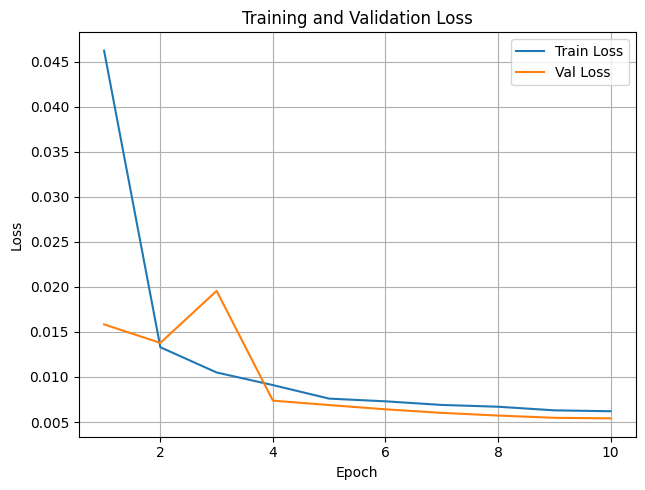

In [15]:
def plot_metrics(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(18, 5))

    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()
    
    
plot_metrics(
    train_losses=metrics_logger.train_losses,
    val_losses=metrics_logger.eval_losses,
)

In [16]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.005626574158668518,
 'eval_runtime': 13.0273,
 'eval_samples_per_second': 62.484,
 'eval_steps_per_second': 0.998,
 'epoch': 10.0}

# Visualization

In [17]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def visualize_model_output(model, dataset, index=0, device="cpu", mean=[0.5]*3, std=[0.5]*3):
    """
    Visualize the model's inpainting result on a dataset sample.

    Args:
        model (nn.Module): Trained inpainting model.
        dataset (Dataset): Dataset instance.
        index (int): Index of the sample to visualize.
        device (str): 'cpu' or 'cuda'.
        mean (list): Normalization mean used during training.
        std (list): Normalization std used during training.
    """
    model.eval()

    # Define inverse normalization
    unnormalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )

    # Get sample and move input to device
    sample = dataset[index]
    input_tensor = sample["pixel_values"].unsqueeze(0).to(device)
    label_tensor = sample["labels"]

    # Forward pass
    with torch.no_grad():
        output_tensor = model(pixel_values=input_tensor)["logits"].squeeze(0).cpu()

    # Unnormalize tensors
    input_img = unnormalize(sample["pixel_values"]).clamp(0, 1)
    output_img = unnormalize(output_tensor).clamp(0, 1)
    label_img = unnormalize(label_tensor).clamp(0, 1)

    # Convert tensors to PIL images
    to_pil = transforms.ToPILImage()
    input_pil = to_pil(input_img)
    output_pil = to_pil(output_img)
    label_pil = to_pil(label_img)

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(input_pil)
    axs[0].set_title("Masked Input")
    axs[1].imshow(output_pil)
    axs[1].set_title("Model Output")
    axs[2].imshow(label_pil)
    axs[2].set_title("Ground Truth")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


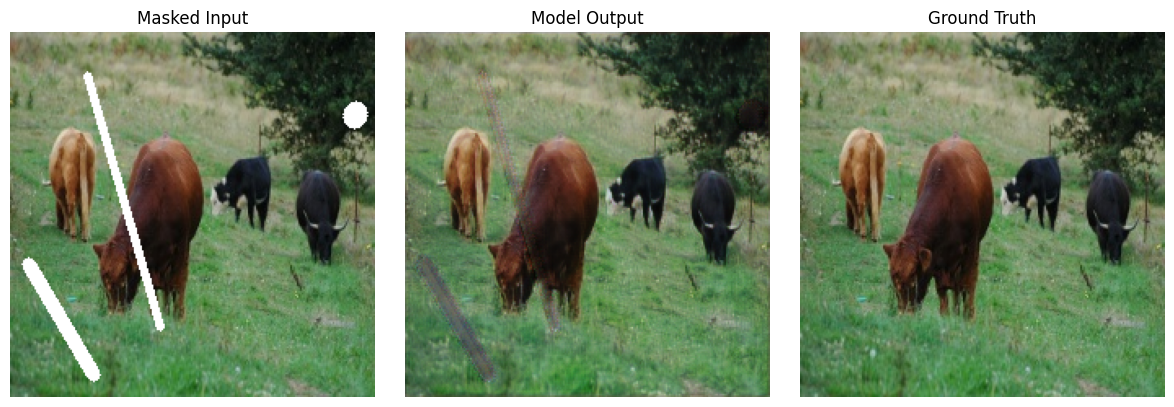

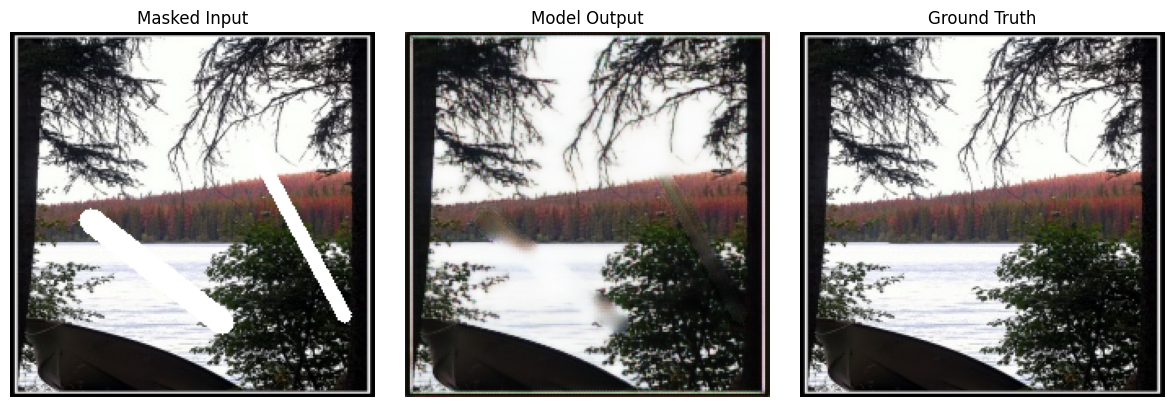

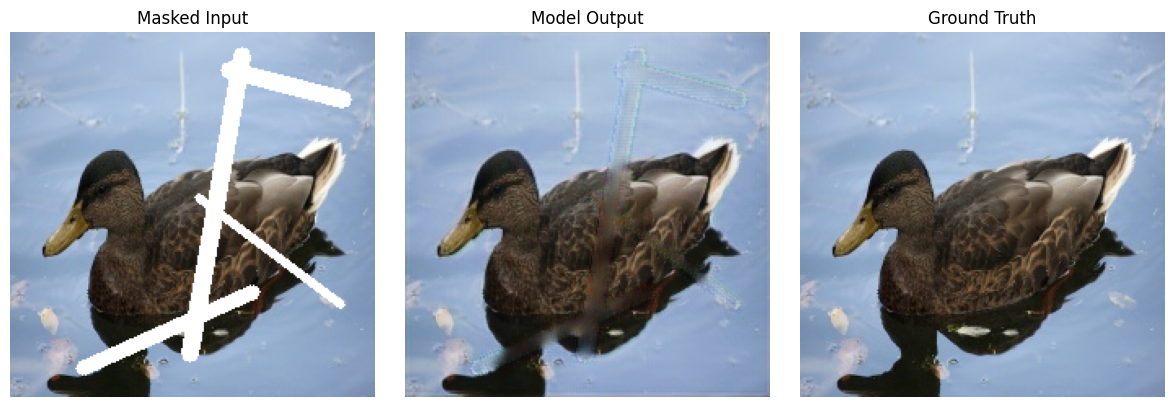

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_model_output(trainer.model, test_dataset, index=0, device=device)
visualize_model_output(trainer.model, test_dataset, index=1, device=device)
visualize_model_output(trainer.model, test_dataset, index=2, device=device)